In [1]:
#Imports
import cv2
from PIL import Image
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline 

from datetime import datetime

# to evaluate the predicted classification
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error,mean_squared_error,mean_squared_log_error

#Note Tensorflow includes the Framework Keras at Version 2.0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

#EarlyStopping: Early stopping to track the val_loss and stop training once it begins increasing too much!
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization

In [2]:
#GLOBAL VARIABLES
# an CNN needs an uniform width,height,channels
g_Image_Shape = (200,200,1)
g_batch_size = 1
g_Folder_Train = 'Images/train'
g_Folder_Test = 'Images/test'
g_Foler_Trimed = 'Images/_trimed/_1'

In [3]:
pwd

'C:\\Users\\mestrovicd\\Desktop\\Wissen\\Deep_Learning\\TF_2_Notebooks_and_Data\\Project'

In [31]:
df = pd.read_csv('Images\\features.csv',sep=';')
#df = pd.read_csv('Images\\Label_Images.csv')

In [54]:
colums = []
for x  in df.columns:
    if x != 'image':
        colums.append(x)

In [55]:
colums

['man', 'women', 'front', 'left', 'right']

In [5]:
columns=["man","women","front","left","right"]
#columns=["canvas","man","women","men","woman","headTohead","front","left","right","topless","garment"]

In [6]:
df

,image,man,women,front,left,right
0,100.jpg,0,1,1,0,0
1,1000.jpg,1,0,1,0,0
2,1001.jpg,1,0,0,1,0
3,1002.jpg,1,0,1,0,0
4,1003.jpg,1,0,0,1,0
...,...,...,...,...,...,...
185,295.jpg,0,1,0,1,0
186,296.jpg,0,1,1,0,0
187,297.jpg,0,1,0,1,0
188,298.jpg,1,0,1,0,0


In [7]:
#This functions helps if you are dealing with small datasets
image_gen = ImageDataGenerator(rotation_range=0, # rotate the image 30 degrees
                                   width_shift_range=0.0, # Shift the pic width by a max of 10%
                                   height_shift_range=0.0, # Shift the pic height by a max of 10%
                                   rescale=1/255, # Rescale the image by normalzing it.
                                   shear_range=0.1, # Shear means cutting away part of the image (max 20%)
                                   zoom_range=0.2, # Zoom in by 20% max
                                   horizontal_flip=False, # Allo horizontal flipping
                                   fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                                  )

In [9]:
#This functions helps if you are dealing with small datasets
test_datagen = ImageDataGenerator(rotation_range=0, # rotate the image 30 degrees
                                   width_shift_range=0.0, # Shift the pic width by a max of 10%
                                   height_shift_range=0.0, # Shift the pic height by a max of 10%
                                   rescale=1/255, # Rescale the image by normalzing it.
                                   shear_range=0.1, # Shear means cutting away part of the image (max 20%)
                                   zoom_range=0.2, # Zoom in by 20% max
                                   horizontal_flip=False, # Allo horizontal flipping
                                   fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                                  )

In [10]:
train_generator = image_gen.flow_from_dataframe(
                                               dataframe=df[:150],
                                               directory=g_Foler_Trimed,
                                                color_mode='grayscale',                                         
                                                x_col="image",
                                               y_col=columns,
                                               batch_size=g_batch_size,
                                               seed=42,
                                               shuffle=True,
                                               class_mode="raw",
                                               target_size=g_Image_Shape[:2]
                                                )

Found 150 validated image filenames.


In [11]:
valid_generator=test_datagen.flow_from_dataframe(
                                               dataframe=df[151:],
                                               directory=g_Foler_Trimed,
                                                color_mode='grayscale', 
                                               x_col="image",
                                               y_col=columns,
                                               batch_size=g_batch_size,
                                               seed=42,
                                               shuffle=True,
                                               class_mode="raw",
                                               target_size=g_Image_Shape[:2]
                                               )

Found 39 validated image filenames.


In [12]:
#test_generator = test_datagen.flow_from_dataframe(
#                                               dataframe=df[101:200],
#                                               directory=g_Foler_Trimed,
#                                               color_mode='grayscale', 
#                                               x_col="image",
#                                              y_col=columns,
#                                               batch_size=g_batch_size,
#                                               seed=42,
#                                               shuffle=True,
#                                               class_mode="raw",
#                                               target_size=g_Image_Shape[:2]
#                                                )

In [13]:
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [14]:
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11),input_shape=g_Image_Shape, strides=(4, 4), activation='relu',))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), padding="same", input_shape=g_Image_Shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3,3),input_shape=g_Image_Shape, padding="valid", activation='relu',))
model.add(Conv2D(filters=384, kernel_size=(3,3),input_shape=g_Image_Shape, padding="valid", activation='relu',))
model.add(Conv2D(filters=256, kernel_size=(3,3),input_shape=g_Image_Shape, padding="valid", activation='relu',))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(1, 1)))

#model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, strides=(1, 1), padding="same", activation='relu',))
#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=128, kernel_size=(5,5),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=128, kernel_size=(5,5),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=64, kernel_size=(7,7),input_shape=g_Image_Shape, strides=(1, 1), padding="same", activation='relu',))
#model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=64, kernel_size=(7,7),input_shape=g_Image_Shape, strides=(1, 1), padding="same", activation='relu',))
#model.add(Conv2D(filters=64, kernel_size=(5,5),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))
#model.add(Dropout(0.33))

#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=g_Image_Shape, activation='relu',))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1)))

model.add(Flatten())

# in regression prediction dense = features
model.add(Dense(4096))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training at every batch.
# Here we say randomly turn off 50% of neurons after the Dense 128.
model.add(Dropout(0.5))

# in regression prediction dense = features
model.add(Dense(4096))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training at every batch.
# Here we say randomly turn off 50% of neurons after the Dense 128.
model.add(Dropout(0.5))

# Dense 3 for 3 Output Layer. 
# It is a multi-classifcation problem
# every Image could be assigned into the class x & y & n (Non_Exclusice Class)
# the sigmoid function can categories the classes 0.00... till 1.00...
#model.add(Dense(11))
model.add(Dense(5))
model.add(Activation('sigmoid'))

# softmax or sigmoid?
# https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/
# sigmoid if on image could have more labels
# softmax if on image should only have on label

# For a multi-class classification problem categorical_crossentropy???
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
        # rmsprop
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 96)        11712     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 256)       8

In [15]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)

In [16]:
# WINDOWS: Use "logs\\fit"
# MACOS/LINUX: Use "logs\fit"

log_directory = 'logs\\fit'

# OPTIONAL: ADD A TIMESTAMP FOR UNIQUE FOLDER
timestamp = datetime.now().strftime("%Y-%m-%d--%H%M")
log_directory = log_directory + '\\' + timestamp

board = TensorBoard(log_dir=log_directory,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    update_freq='epoch',
                    profile_batch=1,
                    embeddings_freq=1)

In [17]:
results = model.fit_generator(train_generator,
                                  epochs=100,
                                  validation_data=valid_generator,
                                  callbacks=[early_stop]
                                  )
                                    #callbacks=[..., board]
                                  #steps_per_epoch= wie viele Images werden per Epoch werden durch das Model analyisert
                                  #batch = wieviele parallele Epochs laufen pro Epoch

Epoch 1/100
150/150 [==============================] - 221s 1s/step - loss: 0.7435 - accuracy: 0.5747 - val_loss: 0.5780 - val_accuracy: 0.5897
Epoch 2/100
150/150 [==============================] - 227s 2s/step - loss: 0.5981 - accuracy: 0.6160 - val_loss: 0.5663 - val_accuracy: 0.6051
Epoch 3/100
150/150 [==============================] - 223s 1s/step - loss: 0.6068 - accuracy: 0.5720 - val_loss: 0.5765 - val_accuracy: 0.5897
Epoch 4/100
150/150 [==============================] - 220s 1s/step - loss: 0.5996 - accuracy: 0.6013 - val_loss: 0.5757 - val_accuracy: 0.5897
Epoch 5/100
150/150 [==============================] - 226s 2s/step - loss: 0.5976 - accuracy: 0.5840 - val_loss: 0.5725 - val_accuracy: 0.6000
Epoch 00005: early stopping


In [18]:
metrics =  pd.DataFrame(model.history.history)

In [19]:
#loss = Verlust in Traindata train_image_gen. Ziel: decrease | Model kennt Ergebnis in Train Data
#var_loss = Verlust in Testdata test_image_gen. Ziel: decrease  | Model kennt Ergebnis in Test Data 
#accuracy = Richtigkeit der Train data (train_image_gen). Ziel: increase
#val_accuracy = Richtigkeit der Test data (test_image_gen). Ziel: increase
#Overfitting = nicht vorhandene Muster im Datensatz erkennt | training data but does not perform well on the evaluation data | "loss" keeps decreasing (abnehmen) while "val_loss" is stale, or increases (zunehmen). 
#Unterfitting = keine relevanten Schlüsse | model is unable to capture the relationship between the input examples & the target values | "loss" and "val_loss" are to far away from each other
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.743458,0.574666,0.577962,0.589744
1,0.598076,0.616000,0.566290,0.605128
2,0.606762,0.572000,0.576485,0.589744
3,0.599587,0.601333,0.575721,0.589744
4,0.597585,0.584000,0.572503,0.600000


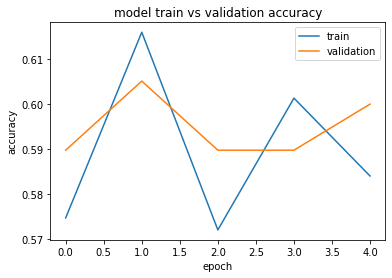

In [20]:
#metrics[['accuracy', 'val_accuracy']].plot()

# plot train and validation loss
plt.plot(metrics[['accuracy']])
plt.plot(metrics[['val_accuracy']])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

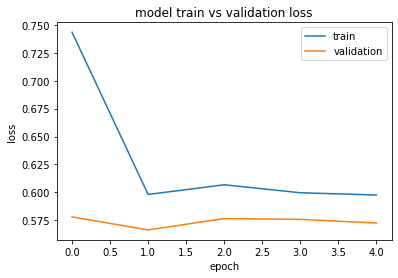

In [21]:
#metrics[['loss', 'val_loss']].plot()

# plot train and validation loss
plt.plot(metrics[['loss']])
plt.plot(metrics[['val_loss']])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
#valid_generator[0]
#STEP_SIZE_VALID
valid_generator.n//valid_generator.batch_size

39

In [23]:
#to get the last Epoch
model.evaluate_generator(generator=valid_generator,steps=2)

[0.610180675983429, 0.4]

In [24]:
model.metrics_names

['loss', 'accuracy']

In [25]:
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()
#pred_probabilities=model.predict_generator(test_generator,verbose=1)
#,steps=100
pred_probabilities=model.predict_generator(valid_generator,verbose=1)
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras

39/39 [==============================] - 7s 169ms/step


In [26]:
pred_probabilities

array([[0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.5199383 , 0.4245803 , 0.07072857],
       [0.4870916 , 0.5146173 , 0.

In [27]:
pred_bool = (pred_probabilities >0.5)

In [28]:
predictions = pred_bool.astype(int)
#columns=["desert", "mountains", "sea", "sunset", "trees"]
classes=["man","women","front","left","right"]
#classes=["canvas","man","women","men","woman","headTohead","front","left","right","topless","garment"]
#columns should be the same order of y_col

In [29]:
predictions

array([[0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0]])

In [30]:
results=pd.DataFrame(predictions, columns=classes)

ValueError: Shape of passed values is (39, 5), indices imply (39, 11)

In [ ]:
results

In [67]:
img = valid_generator[0][0][1]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [34]:
type(valid_generator)

keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [35]:
valid_generator[0]

(array([[[[0.8474012 ],
          [0.8474154 ],
          [0.8474295 ],
          ...,
          [0.932718  ],
          [0.93269664],
          [0.9326754 ]],
 
         [[0.7988162 ],
          [0.7990218 ],
          [0.79922736],
          ...,
          [0.9378136 ],
          [0.93784195],
          [0.9378703 ]],
 
         [[0.65972686],
          [0.66011673],
          [0.6605066 ],
          ...,
          [0.9266491 ],
          [0.9266349 ],
          [0.9266207 ]],
 
         ...,
 
         [[0.89414614],
          [0.89415324],
          [0.89416033],
          ...,
          [0.93902844],
          [0.9390072 ],
          [0.93898594]],
 
         [[0.91227686],
          [0.9122414 ],
          [0.91220593],
          ...,
          [0.93234384],
          [0.93236506],
          [0.93238634]],
 
         [[0.91035503],
          [0.9103621 ],
          [0.9103692 ],
          ...,
          [0.9347777 ],
          [0.9347635 ],
          [0.9347493 ]]],
 
 
        [

In [36]:
valid_generator[0][0]

array([[[[0.5546244 ],
         [0.49537063],
         [0.44144085],
         ...,
         [0.9346853 ],
         [0.9333586 ],
         [0.9328492 ]],

        [[0.5012329 ],
         [0.45777503],
         [0.45279038],
         ...,
         [0.932231  ],
         [0.9240492 ],
         [0.9142614 ]],

        [[0.43806547],
         [0.48556113],
         [0.48873794],
         ...,
         [0.90143645],
         [0.871793  ],
         [0.8660211 ]],

        ...,

        [[0.7402529 ],
         [0.72639364],
         [0.57725596],
         ...,
         [0.8455745 ],
         [0.8565018 ],
         [0.9197628 ]],

        [[0.66786206],
         [0.75188893],
         [0.59626263],
         ...,
         [0.84838253],
         [0.8747269 ],
         [0.91914564]],

        [[0.66596967],
         [0.80542886],
         [0.6908599 ],
         ...,
         [0.8525668 ],
         [0.90631396],
         [0.9205916 ]]],


       [[[0.79215693],
         [0.79215693],
         [0.79

In [37]:
valid_generator[0][1]

array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]], dtype=int64)

In [38]:
valid_generator[0][0][0][0]

array([[0.5645394 ],
       [0.5644528 ],
       [0.5643663 ],
       [0.56427974],
       [0.56419325],
       [0.5641067 ],
       [0.56402016],
       [0.4758723 ],
       [0.42146426],
       [0.49679726],
       [0.48157454],
       [0.47971597],
       [0.43410888],
       [0.33912024],
       [0.3311866 ],
       [0.31237486],
       [0.30510768],
       [0.26825705],
       [0.3165039 ],
       [0.32838956],
       [0.337549  ],
       [0.310376  ],
       [0.32957536],
       [0.2729447 ],
       [0.2891297 ],
       [0.33804318],
       [0.35276207],
       [0.31755474],
       [0.26681867],
       [0.28546134],
       [0.3228685 ],
       [0.2479043 ],
       [0.3517386 ],
       [0.40827516],
       [0.32401508],
       [0.39238986],
       [0.3112907 ],
       [0.27129582],
       [0.2974762 ],
       [0.31932706],
       [0.36456057],
       [0.31653565],
       [0.52758336],
       [0.6435684 ],
       [0.5339082 ],
       [0.5256864 ],
       [0.5945951 ],
       [0.675

In [39]:
img.shape

(100, 100, 1)

In [40]:
img

array([[[0.83001727],
        [0.6248115 ],
        [0.525558  ],
        ...,
        [0.785429  ],
        [0.75761217],
        [0.7046017 ]],

       [[0.83001727],
        [0.6248115 ],
        [0.525558  ],
        ...,
        [0.785429  ],
        [0.75761217],
        [0.7046017 ]],

       [[0.83001727],
        [0.6248115 ],
        [0.525558  ],
        ...,
        [0.785429  ],
        [0.75761217],
        [0.7046017 ]],

       ...,

       [[0.9461561 ],
        [0.9490197 ],
        [0.9490197 ],
        ...,
        [0.92366886],
        [0.80039954],
        [0.484089  ]],

       [[0.9461561 ],
        [0.9490197 ],
        [0.9490197 ],
        ...,
        [0.92366886],
        [0.80039954],
        [0.484089  ]],

       [[0.9461561 ],
        [0.9490197 ],
        [0.9490197 ],
        ...,
        [0.92366886],
        [0.80039954],
        [0.484089  ]]], dtype=float32)

In [41]:
img.reshape(100, 100)

array([[0.83001727, 0.6248115 , 0.525558  , ..., 0.785429  , 0.75761217,
        0.7046017 ],
       [0.83001727, 0.6248115 , 0.525558  , ..., 0.785429  , 0.75761217,
        0.7046017 ],
       [0.83001727, 0.6248115 , 0.525558  , ..., 0.785429  , 0.75761217,
        0.7046017 ],
       ...,
       [0.9461561 , 0.9490197 , 0.9490197 , ..., 0.92366886, 0.80039954,
        0.484089  ],
       [0.9461561 , 0.9490197 , 0.9490197 , ..., 0.92366886, 0.80039954,
        0.484089  ],
       [0.9461561 , 0.9490197 , 0.9490197 , ..., 0.92366886, 0.80039954,
        0.484089  ]], dtype=float32)

TypeError: Invalid shape (100, 100, 1) for image data

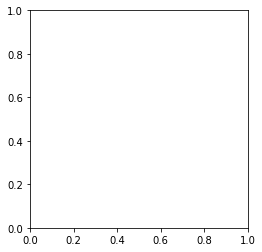

In [42]:
plt.imshow(img,cmap='gray')